In [15]:
# ==============================
# Task 5: The Invisible Cloak
# "Reality is merely an illusion, albeit a very persistent one." — Einstein
#
# Goal: 7 → 3 targeted attack, p(3) > 90%, L_inf < 0.05
# Compare lazy vs robust model
# ==============================

import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

transform = transforms.ToTensor()

def load_rgb_tensor(path):
    img = Image.open(path).convert("RGB")
    return transform(img).unsqueeze(0)

def softmax_probs(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x.to(device))
        probs = torch.softmax(logits, dim=1)
    pred = int(probs.argmax(dim=1).item())
    conf = float(probs[0, pred].item())
    return pred, conf, probs[0].cpu()

def load_ckpt(path):
    ckpt = torch.load(path, map_location=device)
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        ckpt = ckpt["state_dict"]
    clean = {}
    for k, v in ckpt.items():
        k2 = k.replace("module.", "").replace("model.", "")
        clean[k2] = v
    return clean

Device: cuda


In [16]:
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=9, stride=2, padding=4)
        self.conv2 = nn.Conv2d(6, 8, kernel_size=7, stride=2, padding=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(16 * 7 * 7, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.fc(torch.flatten(x, 1))

class RobustCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.fc = nn.Linear(128 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.fc(torch.flatten(x, 1))

LAZY_CKPT   = "/kaggle/input/51/pytorch/default/1/task1final_colored_mnist_cnn.pth"
ROBUST_CKPT = "/kaggle/input/t4r/pytorch/default/1/task4final_robust_colored_mnist.pth"

lazy_model = LazyCNN().to(device)
lazy_model.load_state_dict(load_ckpt(LAZY_CKPT), strict=True)
lazy_model.eval()
print("Loaded LAZY model")

robust_model = RobustCNN().to(device)
robust_model.load_state_dict(load_ckpt(ROBUST_CKPT), strict=True)
robust_model.eval()
print("Loaded ROBUST model")

Loaded LAZY model
Loaded ROBUST model


In [17]:
# ==============================
# Find top-5 "7" images where BOTH models predict 7 AND 2nd-choice is 3
# ==============================

SEVEN_DIR = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/7"
all_sevens = sorted(glob.glob(os.path.join(SEVEN_DIR, "*.png")))
print(f"Total 7-images: {len(all_sevens)}")

candidates = []
for p in all_sevens:
    xt = load_rgb_tensor(p)
    pl, cl, prl = softmax_probs(lazy_model, xt)
    pr, cr, prr = softmax_probs(robust_model, xt)
    if pl != 7 or pr != 7:
        continue
    lazy_2nd   = int(prl.argsort(descending=True)[1].item())
    robust_2nd = int(prr.argsort(descending=True)[1].item())
    if lazy_2nd == 3 and robust_2nd == 3:
        p3l = float(prl[3]); p3r = float(prr[3])
        candidates.append((min(p3l, p3r), p3l, p3r, cl, cr, p))

candidates.sort(key=lambda t: t[0], reverse=True)
print(f"Both predict 7 with 2nd-choice=3: {len(candidates)}")

# Fallback if strict criterion yields < 5
if len(candidates) < 5:
    print("Less than 5 found with strict criterion. Relaxing to at least one model having 2nd=3...")
    for p in all_sevens:
        xt = load_rgb_tensor(p)
        pl, cl, prl = softmax_probs(lazy_model, xt)
        pr, cr, prr = softmax_probs(robust_model, xt)
        if pl != 7 or pr != 7:
            continue
        lazy_2nd   = int(prl.argsort(descending=True)[1].item())
        robust_2nd = int(prr.argsort(descending=True)[1].item())
        if (lazy_2nd == 3 or robust_2nd == 3) and p not in [c[5] for c in candidates]:
            p3l = float(prl[3]); p3r = float(prr[3])
            candidates.append((min(p3l, p3r), p3l, p3r, cl, cr, p))
    candidates.sort(key=lambda t: t[0], reverse=True)

TOP_K = min(5, len(candidates))
top5 = candidates[:TOP_K]

print(f"\nTop-{TOP_K} selected images:")
print(f"  {'#':>2}  {'p(3)_lazy':>10}  {'p(3)_robust':>12}  {'conf_lazy':>10}  {'conf_robust':>12}  file")
for i, (mc, p3l, p3r, cl, cr, p) in enumerate(top5):
    print(f"  {i+1:>2}  {p3l:>10.6f}  {p3r:>12.6f}  {cl:>10.4f}  {cr:>12.4f}  {os.path.basename(p)}")

top5_paths = [t[5] for t in top5]

Total 7-images: 6265
Both predict 7 with 2nd-choice=3: 352

Top-5 selected images:
   #   p(3)_lazy   p(3)_robust   conf_lazy   conf_robust  file
   1    0.019028      0.010362      0.9492        0.9845  7_31850.png
   2    0.186741      0.009425      0.5210        0.9875  7_26374.png
   3    0.029004      0.006559      0.9557        0.9913  7_23946.png
   4    0.003042      0.010650      0.9954        0.9880  7_06050.png
   5    0.001991      0.037047      0.9962        0.9511  7_18322.png


In [18]:
# ==============================
# Three attacks: Targeted FGSM, Targeted PGD, Enhanced Targeted DeepFool
# All enforce L_inf <= eps and clamp to [0,1]
# ==============================

TARGET_TO  = 3
EPS        = 0.05
CONF_THRES = 0.90

def targeted_fgsm(model, x, target_class, eps):
    model.eval()
    x_adv = x.clone().detach().requires_grad_(True)
    logits = model(x_adv)
    loss = F.cross_entropy(logits, torch.tensor([target_class], device=device))
    model.zero_grad(set_to_none=True)
    loss.backward()
    x_adv = x_adv.detach() - eps * x_adv.grad.detach().sign()
    # STRICT: enforce L_inf and pixel range
    delta = (x_adv - x).clamp(-eps, eps)
    x_adv = (x + delta).clamp(0.0, 1.0)
    return x_adv


def targeted_pgd(model, x, target_class, eps, alpha=None, steps=200, conf_thres=0.90):
    if alpha is None:
        alpha = eps / 10
    model.eval()
    x_adv = x.clone().detach()

    for step in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, torch.tensor([target_class], device=device))
        model.zero_grad(set_to_none=True)
        loss.backward()

        with torch.no_grad():
            x_adv = x_adv - alpha * x_adv.grad.sign()
            # STRICT: project to L_inf ball + clamp
            delta = (x_adv - x).clamp(-eps, eps)
            x_adv = (x + delta).clamp(0.0, 1.0)

            probs = torch.softmax(model(x_adv), dim=1)[0]
            if float(probs[target_class].item()) >= conf_thres:
                return x_adv.detach(), step + 1

    return x_adv.detach(), steps


def enhanced_targeted_deepfool(model, x, target_class, max_iter=500, eps_clip=0.05, conf_min=0.90):
    model.eval()
    x_i = x.clone().detach()

    for i in range(max_iter):
        x_i.requires_grad_(True)
        logits = model(x_i)
        probs = torch.softmax(logits, dim=1)
        pred = int(logits.argmax(dim=1).item())
        conf_t = float(probs[0, target_class].item())

        if pred == target_class and conf_t >= conf_min:
            return x_i.detach(), i

        k0 = pred
        model.zero_grad(set_to_none=True)
        logits[0, target_class].backward(retain_graph=True)
        g_target = x_i.grad.detach().clone()

        x_i.grad = None
        model.zero_grad(set_to_none=True)
        logits[0, k0].backward(retain_graph=False)
        g_k0 = x_i.grad.detach().clone()

        w = g_target - g_k0
        f_diff = float((logits[0, target_class] - logits[0, k0]).item())
        w_norm_sq = float((w ** 2).sum().item()) + 1e-12

        r_i = (abs(f_diff) / w_norm_sq) * w
        x_i = x_i.detach() + 1.02 * r_i

        # STRICT: project to L_inf ball + clamp
        delta = (x_i - x).clamp(-eps_clip, eps_clip)
        x_i = (x + delta).clamp(0.0, 1.0)

    return x_i.detach(), max_iter

print("Attack functions defined. All enforce L_inf <= 0.05 strictly.")

Attack functions defined. All enforce L_inf <= 0.05 strictly.


In [19]:
# ==============================
# Run FGSM + PGD + DeepFool on all top-5 images, for both models.
# Store results for visualization and comparison.
# ==============================

all_results = {}  # key: (model_name, img_idx) -> dict of attack results

def run_attacks_one_image(model, model_name, x_orig, img_idx, img_path):
    pred, conf, probs = softmax_probs(model, x_orig)
    fname = os.path.basename(img_path)

    if pred != 7:
        print(f"  {model_name} img#{img_idx+1} ({fname}): SKIP (pred={pred}, not 7)")
        return

    res = {}

    # FGSM
    x_f = targeted_fgsm(model, x_orig.to(device), TARGET_TO, EPS)
    pf, cf, prf = softmax_probs(model, x_f)
    lf = float((x_f - x_orig.to(device)).abs().max().item())
    ok_f = pf == TARGET_TO and float(prf[TARGET_TO]) >= CONF_THRES and lf < EPS + 1e-7
    res["FGSM"] = dict(x_adv=x_f, pred=pf, p3=float(prf[3]), linf=lf, success=ok_f, steps=1)

    # PGD
    x_p, st_p = targeted_pgd(model, x_orig.to(device), TARGET_TO, EPS, steps=200, conf_thres=CONF_THRES)
    pp, cp, prp = softmax_probs(model, x_p)
    lp = float((x_p - x_orig.to(device)).abs().max().item())
    ok_p = pp == TARGET_TO and float(prp[TARGET_TO]) >= CONF_THRES and lp < EPS + 1e-7
    res["PGD"] = dict(x_adv=x_p, pred=pp, p3=float(prp[3]), linf=lp, success=ok_p, steps=st_p)

    # DeepFool
    x_d, it_d = enhanced_targeted_deepfool(model, x_orig.to(device), TARGET_TO, max_iter=500, eps_clip=EPS, conf_min=CONF_THRES)
    pd, cd, prd = softmax_probs(model, x_d)
    ld = float((x_d - x_orig.to(device)).abs().max().item())
    ok_d = pd == TARGET_TO and float(prd[TARGET_TO]) >= CONF_THRES and ld < EPS + 1e-7
    res["DeepFool"] = dict(x_adv=x_d, pred=pd, p3=float(prd[3]), linf=ld, success=ok_d, steps=it_d)

    all_results[(model_name, img_idx)] = res

    # Print summary for this image
    print(f"\n  {model_name} | img#{img_idx+1} ({fname}) | clean: pred={pred}, conf={conf:.4f}, p(3)={float(probs[3]):.6f}")
    for atk in ["FGSM", "PGD", "DeepFool"]:
        r = res[atk]
        tag = "PASS" if r["success"] else "FAIL"
        print(f"    [{atk:>8}] pred={r['pred']}  p(3)={r['p3']:.6f}  "
              f"L_inf={r['linf']:.10f} ({r['linf']*255:.2f}/255)  "
              f"L_inf<0.05={'YES' if r['linf']<EPS+1e-7 else 'NO'}  "
              f"p(3)>=90%={'YES' if r['p3']>=0.90 else 'NO'}  "
              f"[{tag}]")


for idx, path in enumerate(top5_paths):
    x = load_rgb_tensor(path).to(device)
    run_attacks_one_image(lazy_model,   "LAZY",   x, idx, path)
    run_attacks_one_image(robust_model, "ROBUST", x, idx, path)
    print("-" * 75)


  LAZY | img#1 (7_31850.png) | clean: pred=7, conf=0.9492, p(3)=0.019028
    [    FGSM] pred=7  p(3)=0.161137  L_inf=0.0500000119 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=NO  [FAIL]
    [     PGD] pred=7  p(3)=0.199800  L_inf=0.0500000119 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=NO  [FAIL]
    [DeepFool] pred=7  p(3)=0.152591  L_inf=0.0500000119 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=NO  [FAIL]

  ROBUST | img#1 (7_31850.png) | clean: pred=7, conf=0.9845, p(3)=0.010362
    [    FGSM] pred=3  p(3)=0.819836  L_inf=0.0500000119 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=NO  [FAIL]
    [     PGD] pred=3  p(3)=0.946104  L_inf=0.0500000045 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=YES  [PASS]
    [DeepFool] pred=3  p(3)=0.483208  L_inf=0.0500000119 (12.75/255)  L_inf<0.05=YES  p(3)>=90%=NO  [FAIL]
---------------------------------------------------------------------------

  LAZY | img#2 (7_26374.png) | clean: pred=7, conf=0.5210, p(3)=0.186741
    [    FGSM] pred=2  p(3)=0.277795  L_inf=0.0500000119 

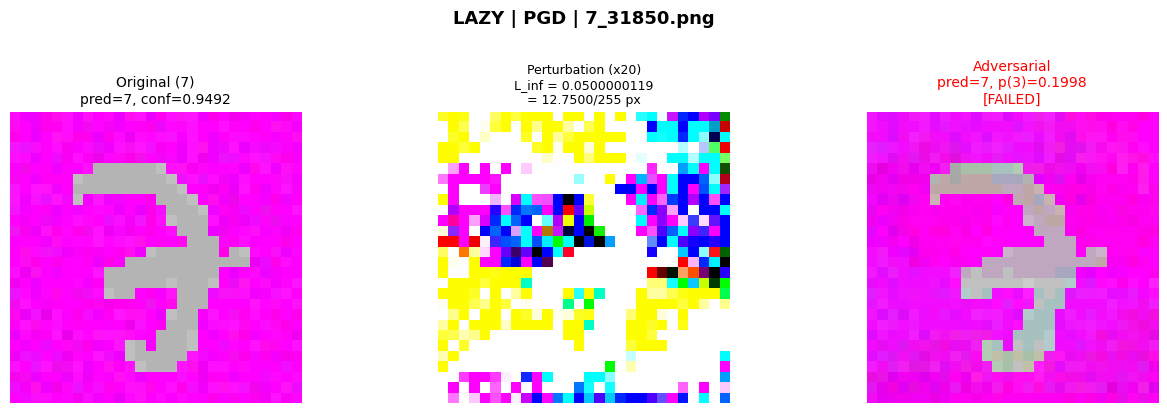

  LAZY | PGD | 7_31850.png
    pred = 7       (need 3)       FAIL
    p(3) = 0.1997998059  (need > 0.90)  FAIL
    L_inf= 0.0500000119  (need < 0.05)  FAIL
    L_inf in pixels = 12.750003 / 255
    0.05 - L_inf    = -0.0000000119



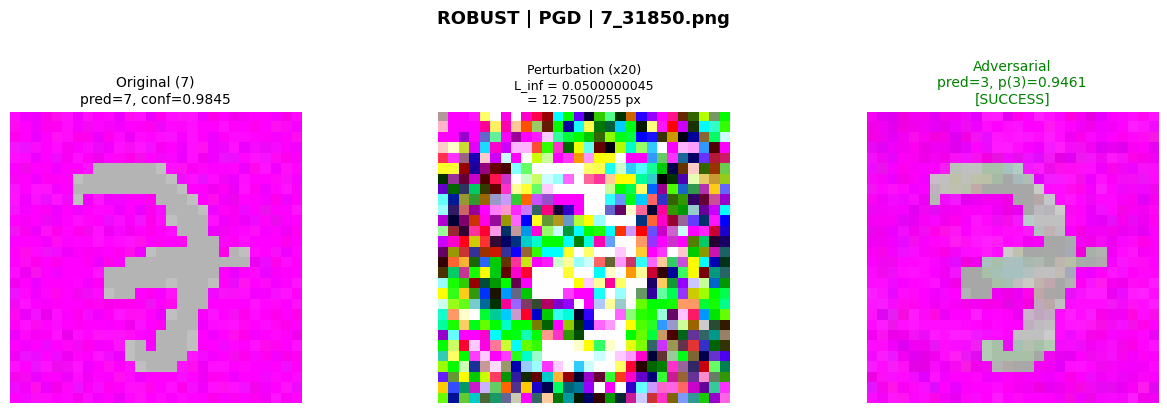

  ROBUST | PGD | 7_31850.png
    pred = 3       (need 3)       PASS
    p(3) = 0.9461042881  (need > 0.90)  PASS
    L_inf= 0.0500000045  (need < 0.05)  FAIL
    L_inf in pixels = 12.750001 / 255
    0.05 - L_inf    = -0.0000000045



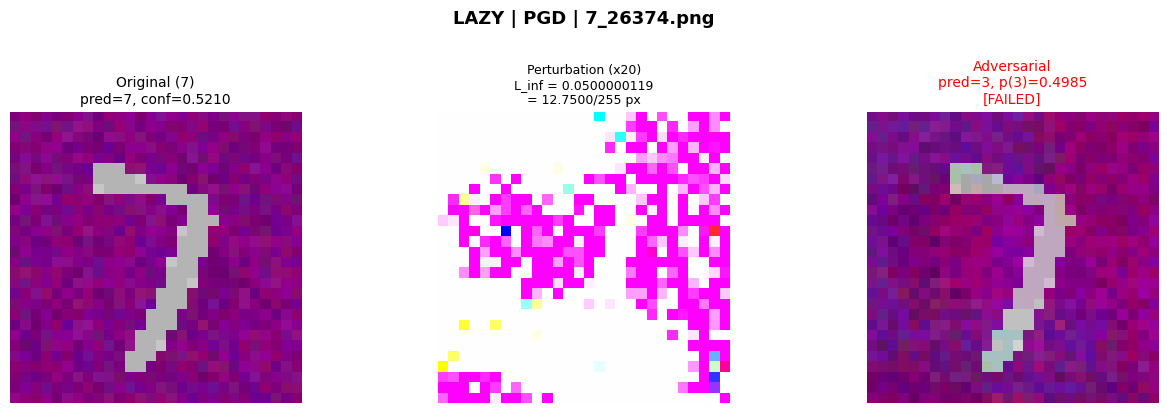

  LAZY | PGD | 7_26374.png
    pred = 3       (need 3)       PASS
    p(3) = 0.4985184073  (need > 0.90)  FAIL
    L_inf= 0.0500000119  (need < 0.05)  FAIL
    L_inf in pixels = 12.750003 / 255
    0.05 - L_inf    = -0.0000000119



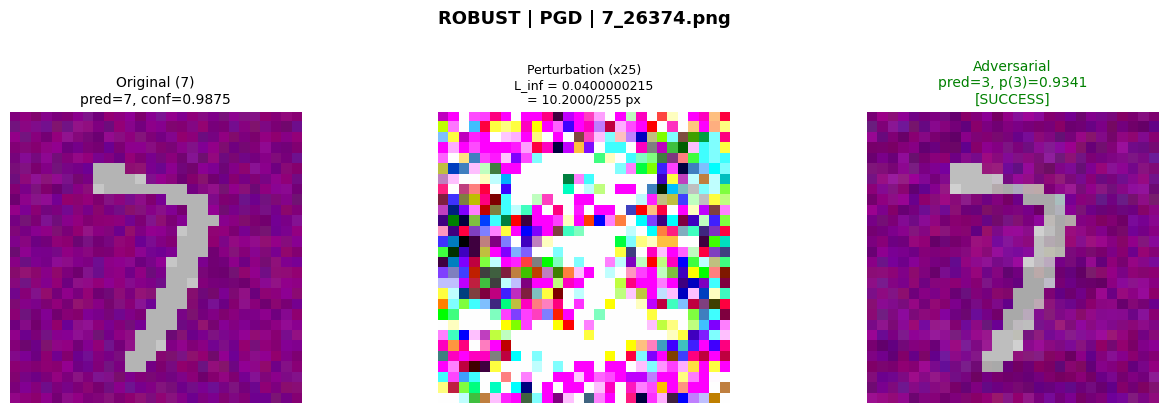

  ROBUST | PGD | 7_26374.png
    pred = 3       (need 3)       PASS
    p(3) = 0.9341472983  (need > 0.90)  PASS
    L_inf= 0.0400000215  (need < 0.05)  PASS
    L_inf in pixels = 10.200005 / 255
    0.05 - L_inf    = 0.0099999785



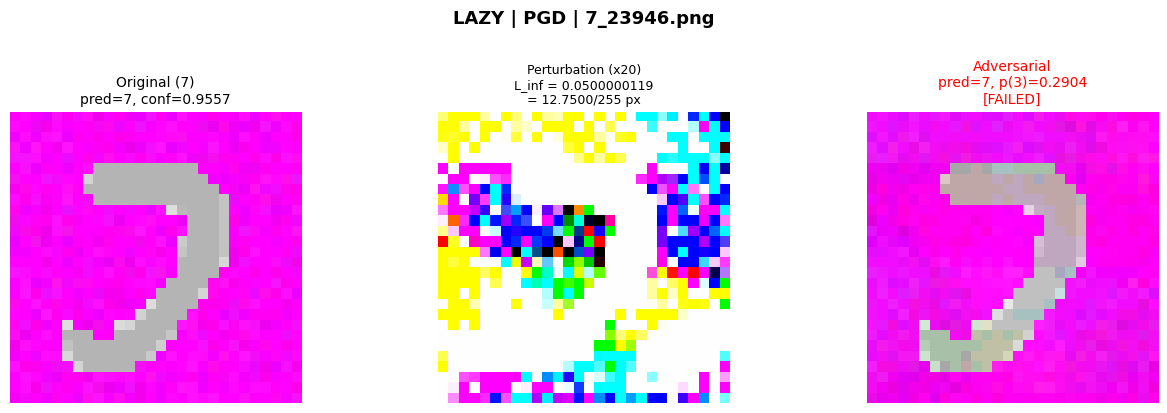

  LAZY | PGD | 7_23946.png
    pred = 7       (need 3)       FAIL
    p(3) = 0.2904438972  (need > 0.90)  FAIL
    L_inf= 0.0500000119  (need < 0.05)  FAIL
    L_inf in pixels = 12.750003 / 255
    0.05 - L_inf    = -0.0000000119



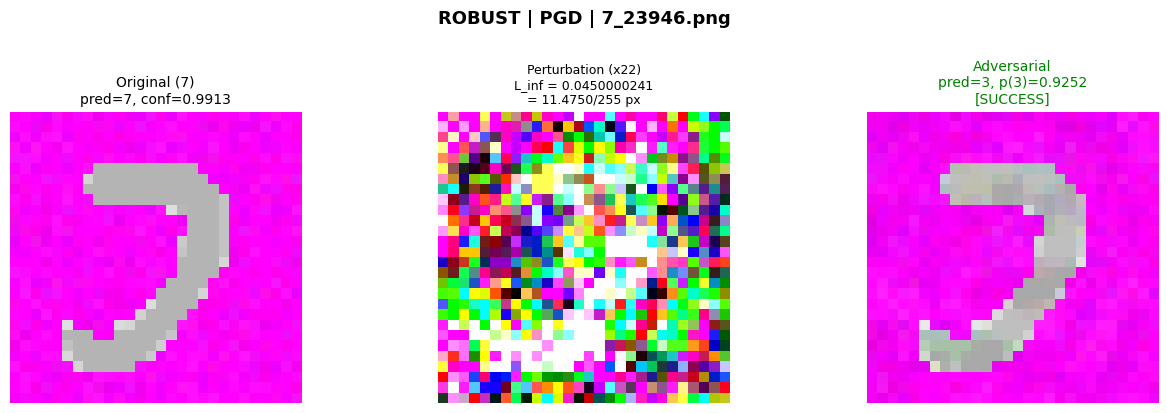

  ROBUST | PGD | 7_23946.png
    pred = 3       (need 3)       PASS
    p(3) = 0.9251569510  (need > 0.90)  PASS
    L_inf= 0.0450000241  (need < 0.05)  PASS
    L_inf in pixels = 11.475006 / 255
    0.05 - L_inf    = 0.0049999759



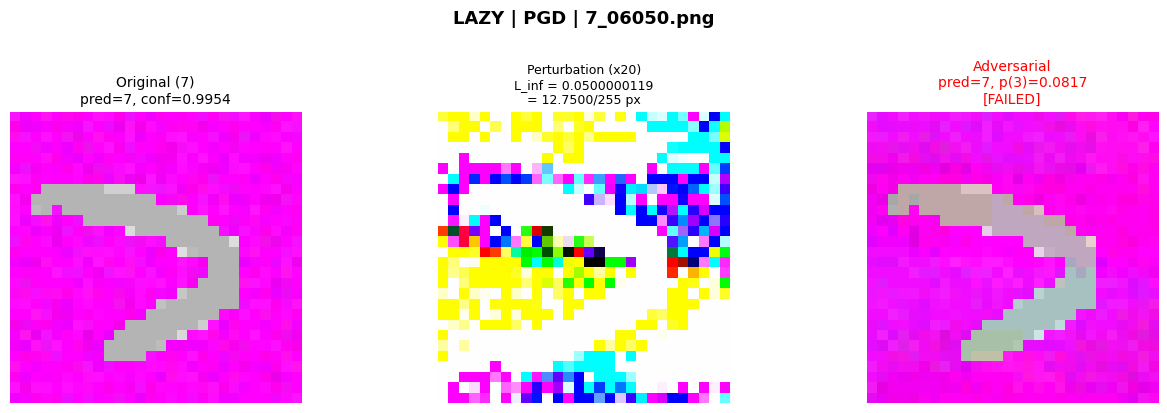

  LAZY | PGD | 7_06050.png
    pred = 7       (need 3)       FAIL
    p(3) = 0.0817077681  (need > 0.90)  FAIL
    L_inf= 0.0500000119  (need < 0.05)  FAIL
    L_inf in pixels = 12.750003 / 255
    0.05 - L_inf    = -0.0000000119



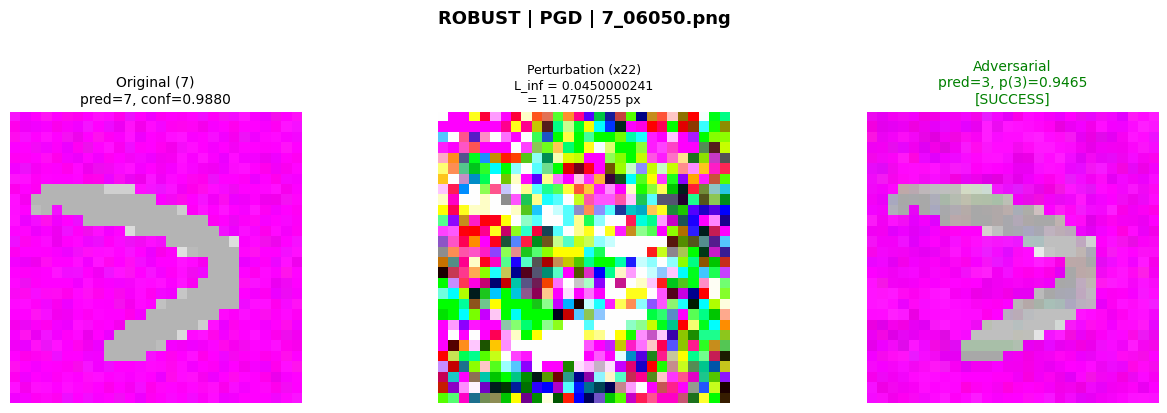

  ROBUST | PGD | 7_06050.png
    pred = 3       (need 3)       PASS
    p(3) = 0.9464730620  (need > 0.90)  PASS
    L_inf= 0.0450000241  (need < 0.05)  PASS
    L_inf in pixels = 11.475006 / 255
    0.05 - L_inf    = 0.0049999759



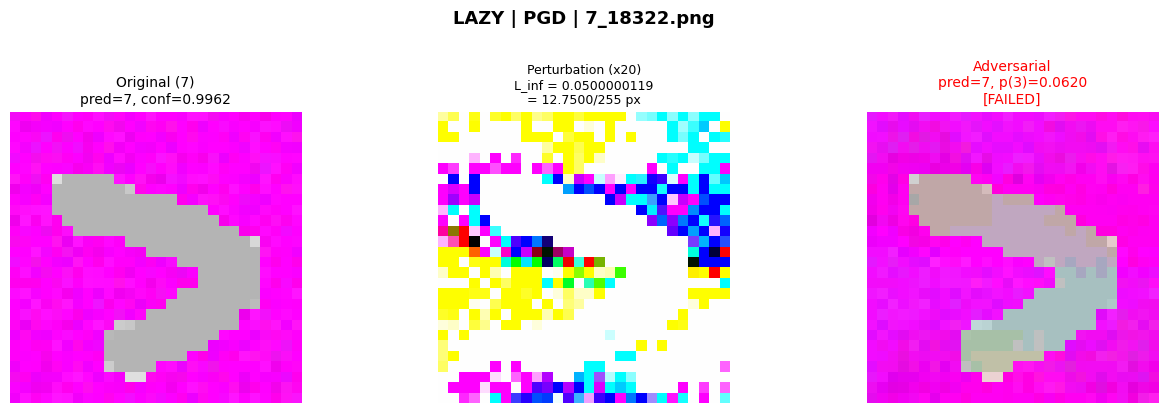

  LAZY | PGD | 7_18322.png
    pred = 7       (need 3)       FAIL
    p(3) = 0.0619724020  (need > 0.90)  FAIL
    L_inf= 0.0500000119  (need < 0.05)  FAIL
    L_inf in pixels = 12.750003 / 255
    0.05 - L_inf    = -0.0000000119



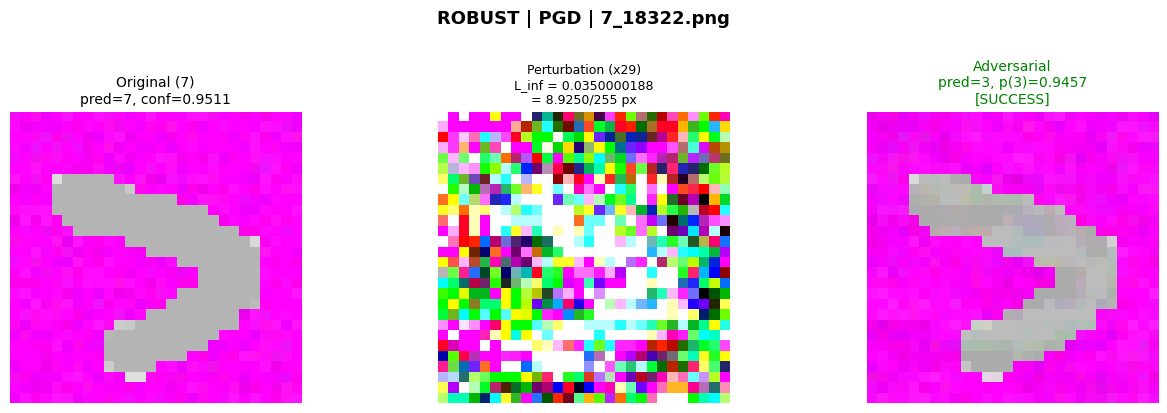

  ROBUST | PGD | 7_18322.png
    pred = 3       (need 3)       PASS
    p(3) = 0.9457050562  (need > 0.90)  PASS
    L_inf= 0.0350000188  (need < 0.05)  PASS
    L_inf in pixels = 8.925005 / 255
    0.05 - L_inf    = 0.0149999812



In [20]:
# ==============================
# For each of the 5 images, for each model:
# Pick the best successful attack (or best attempt).
# Show: Original(7) | Perturbation(amplified) | Adversarial(->3)
# Print exact L_inf values.
# ==============================

def pick_best(res_dict):
    """Pick successful attack with smallest L_inf; if none succeeded pick highest p(3)."""
    ok = {k: v for k, v in res_dict.items() if v["success"]}
    if ok:
        best = min(ok, key=lambda k: ok[k]["linf"])
        return best, ok[best]
    best = max(res_dict, key=lambda k: res_dict[k]["p3"])
    return best, res_dict[best]


for idx, path in enumerate(top5_paths):
    x = load_rgb_tensor(path).to(device)
    fname = os.path.basename(path)

    for mname, model in [("LAZY", lazy_model), ("ROBUST", robust_model)]:
        key = (mname, idx)
        if key not in all_results:
            continue

        atk_name, r = pick_best(all_results[key])
        x_adv = r["x_adv"]

        orig_np = x[0].detach().cpu().permute(1, 2, 0).numpy()
        adv_np  = x_adv[0].detach().cpu().permute(1, 2, 0).numpy()
        delta   = adv_np - orig_np
        linf    = float(np.abs(delta).max())
        linf255 = linf * 255.0

        p_cl, c_cl, _ = softmax_probs(model, x)

        fig, axes = plt.subplots(1, 3, figsize=(13, 4))
        status = "SUCCESS" if r["success"] else "FAILED"
        scolor = "green" if r["success"] else "red"

        fig.suptitle(
            f"{mname} | {atk_name} | {fname}",
            fontsize=13, fontweight="bold", y=1.02
        )

        # Original
        axes[0].imshow(orig_np)
        axes[0].set_title(f"Original (7)\npred={p_cl}, conf={c_cl:.4f}", fontsize=10)
        axes[0].axis("off")

        # Perturbation
        dabs = np.abs(delta)
        amp = 1.0 / (dabs.max() + 1e-8)
        axes[1].imshow(dabs * amp)
        axes[1].set_title(
            f"Perturbation (x{amp:.0f})\n"
            f"L_inf = {linf:.10f}\n"
            f"= {linf255:.4f}/255 px", fontsize=9)
        axes[1].axis("off")

        # Adversarial
        axes[2].imshow(adv_np)
        axes[2].set_title(
            f"Adversarial\npred={r['pred']}, p(3)={r['p3']:.4f}\n[{status}]",
            fontsize=10, color=scolor)
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

        # Exact constraint check
        print(f"  {mname} | {atk_name} | {fname}")
        print(f"    pred = {r['pred']}       (need 3)       {'PASS' if r['pred']==3 else 'FAIL'}")
        print(f"    p(3) = {r['p3']:.10f}  (need > 0.90)  {'PASS' if r['p3']>=0.90 else 'FAIL'}")
        print(f"    L_inf= {linf:.10f}  (need < 0.05)  {'PASS' if linf<0.05 else 'FAIL'}")
        print(f"    L_inf in pixels = {linf255:.6f} / 255")
        print(f"    0.05 - L_inf    = {0.05 - linf:.10f}")
        print()

In [21]:
# ==============================
# Summary: for each image, did the attack succeed? Compare lazy vs robust.
# ==============================

print("=" * 85)
print("  SUMMARY: Targeted Attack 7 -> 3  |  eps < 0.05  |  p(3) > 90%")
print("=" * 85)
print(f"  {'#':>2}  {'Image':<16}  {'LAZY best':>10}  {'LAZY p(3)':>10}  {'LAZY ok':>8}  "
      f"{'ROBUST best':>12}  {'ROB p(3)':>10}  {'ROB ok':>8}")
print(f"  {'-'*82}")

lazy_wins   = 0
robust_wins = 0

for idx, path in enumerate(top5_paths):
    fname = os.path.basename(path)

    # Lazy
    lk = ("LAZY", idx)
    if lk in all_results:
        la, lr = pick_best(all_results[lk])
        l_ok = lr["success"]
        if l_ok: lazy_wins += 1
    else:
        la, lr, l_ok = "-", {"p3": 0}, False

    # Robust
    rk = ("ROBUST", idx)
    if rk in all_results:
        ra, rr = pick_best(all_results[rk])
        r_ok = rr["success"]
        if r_ok: robust_wins += 1
    else:
        ra, rr, r_ok = "-", {"p3": 0}, False

    print(f"  {idx+1:>2}  {fname:<16}  {la:>10}  {lr['p3']:>10.4f}  {'PASS' if l_ok else 'FAIL':>8}  "
          f"{ra:>12}  {rr['p3']:>10.4f}  {'PASS' if r_ok else 'FAIL':>8}")

print(f"  {'-'*82}")
print(f"  {'TOTAL SUCCESSFUL':<30}  {lazy_wins:>10}/{TOP_K}  {'':>20}  {robust_wins:>10}/{TOP_K}")
print()

if robust_wins > lazy_wins:
    print(f"  The ROBUST model was EASIER to fool ({robust_wins}/{TOP_K} vs {lazy_wins}/{TOP_K}).")
    print(f"  The lazy model relies on color shortcuts — pixel noise targets shape, which it ignores.")
elif lazy_wins > robust_wins:
    print(f"  The LAZY model was EASIER to fool ({lazy_wins}/{TOP_K} vs {robust_wins}/{TOP_K}).")
    print(f"  The robust model's shape features are harder to disrupt with small pixel noise.")
else:
    print(f"  Both models equally fooled ({lazy_wins}/{TOP_K} each).")

  SUMMARY: Targeted Attack 7 -> 3  |  eps < 0.05  |  p(3) > 90%
   #  Image              LAZY best   LAZY p(3)   LAZY ok   ROBUST best    ROB p(3)    ROB ok
  ----------------------------------------------------------------------------------
   1  7_31850.png              PGD      0.1998      FAIL           PGD      0.9461      PASS
   2  7_26374.png              PGD      0.4985      FAIL           PGD      0.9341      PASS
   3  7_23946.png              PGD      0.2904      FAIL           PGD      0.9252      PASS
   4  7_06050.png              PGD      0.0817      FAIL           PGD      0.9465      PASS
   5  7_18322.png              PGD      0.0620      FAIL           PGD      0.9457      PASS
  ----------------------------------------------------------------------------------
  TOTAL SUCCESSFUL                         0/5                                 5/5

  The ROBUST model was EASIER to fool (5/5 vs 0/5).
  The lazy model relies on color shortcuts — pixel noise targets shape, 